In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform, io, img_as_float


def imgPreprocess(img_path, size=224):
    """
    Process the image by removing the mean and reszing so that the smallest
    edge is 256. Then take crops and average to predict.
    """
    mean = np.array([103.939, 116.779, 123.68])
    img = img_as_float(io.imread(img_path)).astype(np.float32)
    # Resize factor, smallest edge to 256.
    resFac = 256.0/min(img.shape[:2])
    newSize = list(map(int, (img.shape[0]*resFac, img.shape[1]*resFac)))
    img = transform.resize(img, newSize, mode='constant')
    # Calculate offsets of oversampling from caffe's oversample.
    if (size == 224):
        offset = [[0, 0], [0, newSize[1]-224], [newSize[0]-224, 0], [
                 newSize[0]-224, newSize[1]-224], [
                 newSize[0]/2.0-112, newSize[1]/2.0-112]]
    else:
        offset = [[0, 0], [0, newSize[1]-227], [newSize[0]-227, 0], [
                 newSize[0]-227, newSize[1]-227], [
                 newSize[0]/2.0-114, newSize[1]/2.0-114]]
    img = img*255.0
    img[:, :, 0] -= mean[2]
    img[:, :, 1] -= mean[1]
    img[:, :, 2] -= mean[0]
    return img, offset, resFac,  newSize

def oversample(images, crop_dims):
    NUM_OVER_SAMPLES=10
    """
    Crop images into the four corners, center, and their mirrored versions.
    Parameters
    ----------
    image : iterable of (H x W x K) ndarrays
    crop_dims : (height, width) tuple for the crops.
    Returns
    -------
    crops : (10*N x H x W x K) ndarray of crops for number of inputs N.
    """
    # Dimensions and center.
    im_shape = np.array(images[0].shape)
    crop_dims = np.array(crop_dims)
    im_center = im_shape[:2] / 2.0

    # Make crop coordinates
    h_indices = (0, im_shape[0] - crop_dims[0])
    w_indices = (0, im_shape[1] - crop_dims[1])
    crops_ix = np.empty((5, 4), dtype=int)
    curr = 0
    for i in h_indices:
        for j in w_indices:
            crops_ix[curr] = (i, j, i + crop_dims[0], j + crop_dims[1])
            curr += 1
    crops_ix[4] = np.tile(im_center, (1, 2)) + np.concatenate([
        -crop_dims / 2.0,
         crop_dims / 2.0
    ])
    crops_ix = np.tile(crops_ix, (2, 1))

    # Extract crops
    crops = np.empty((NUM_OVER_SAMPLES * len(images), crop_dims[0], crop_dims[1],
                      im_shape[-1]), dtype=np.float32)
    ix = 0
    for im in images:
        for crop in crops_ix:
            crops[ix] = im[crop[0]:crop[2], crop[1]:crop[3], :]
            ix += 1
        crops[ix-5:ix] = crops[ix-5:ix, :, ::-1, :]  # flip for mirrors
    return crops


In [2]:
#import libraries



import matplotlib.pyplot as plt
import math
import cv2
import os
import numpy as np
import tensorflow as tf
%matplotlib inline
img, offset, resFac, newSize = imgPreprocess(img_path="sample.jpg")
img=oversample([img], (224, 224))
print(img.shape)
net_data=np.load(open("bvlc_alexnet.npy", "rb"), encoding="latin1").item()
print(net_data["conv1"][0].shape)
print(net_data["conv2"][0].shape)
print(net_data["conv3"][0].shape)
print(net_data["conv4"][0].shape)
print(net_data["conv5"][0].shape)

print(net_data["fc6"][0].shape)
print(net_data["fc7"][0].shape)
print(net_data["fc8"][0].shape)

print(net_data["conv1"][1].shape)
print(net_data["conv2"][1].shape)
print(net_data["conv3"][1].shape)
print(net_data["conv4"][1].shape)
print(net_data["conv5"][1].shape)

print(net_data["fc6"][1].shape)
print(net_data["fc7"][1].shape)
print(net_data["fc8"][1].shape)

(10, 224, 224, 3)
(11, 11, 3, 96)
(5, 5, 48, 256)
(3, 3, 256, 384)
(3, 3, 192, 384)
(3, 3, 192, 256)
(9216, 4096)
(4096, 4096)
(4096, 1000)
(96,)
(256,)
(384,)
(384,)
(256,)
(4096,)
(4096,)
(1000,)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[[ array([[[ 44,  41,  45],
        [ 53,  50,  56],
        [ 47,  44,  50],
        ..., 
        [ 92,  95,  92],
        [104, 110, 103],
        [110, 119, 108]],

       [[ 41,  38,  42],
        [ 46,  43,  46],
        [ 44,  41,  45],
        ..., 
        [ 66,  65,  66],
        [ 77,  77,  75],
        [111, 114, 108]],

       [[ 42,  39,  43],
        [ 44,  41,  44],
        [ 43,  40,  44],
        ..., 
        [ 91,  98,  93],
        [ 83,  88,  84],
        [ 71,  73,  70]],

       ..., 
       [[119, 114, 116],
        [125, 119, 125],
        [134, 130, 129],
        ..., 
        [135, 142, 132],
        [132, 138, 129],
        [121, 127, 120]],

       [[176, 171, 174],
        [142, 136, 142],
        [160, 157, 155],
        ..., 
        [139, 141, 134],
        [125, 128, 120],
        [117, 122, 114]],

       [[146, 140, 146],
        [156, 150, 155],
        [167, 163, 161],
        ..., 
        [119

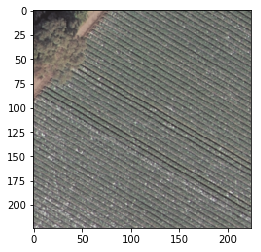

In [13]:
#data load 
lb=list(os.walk("../../datasets/UCMerced_LandUse/Images"))[0][1]
#print(list(lb))
n_classes=21
a = np.arange(n_classes)
#print(a)
b = np.zeros((n_classes, n_classes))
b[np.arange(n_classes), a] = 1
#print(b)

data=[]

for i in range(n_classes):
    for j in range(100):
        if(j<10):
            p='0'
        else:
            p=''
        path='../../datasets/UCMerced_LandUse/Images/'+lb[i]+'/'+lb[i]+p+str(j)+'.tif'
        tmp=[]
        t=plt.imread(path)
        t=np.delete(t,224+np.arange(t.shape[0]-224),axis=0)
        t=np.delete(t,224+np.arange(t.shape[1]-224),axis=1)
       
        tmp.append(t)
        tmp.append(b[i])
        
        data.append(tmp)
        #print(i,' ',j)
    print(i)

data=np.array(data)
plt.imshow(data[0][0])

print(data)



[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]


(224, 224, 3)

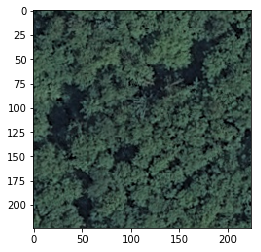

In [14]:
print(data[4][1])
data1=np.random.shuffle(data)

print(data[4][1])
plt.imshow(data[4][0])
data[0][0].shape

In [15]:
size=224
image=np.zeros((n_classes*100,size,size,3))
label=np.zeros((n_classes*100,n_classes))
for i in range(n_classes*100):
    print(i)
    print(data[i,0].shape)
    image[i]=data[i,0].tolist()
    label[i]=data[i,1].tolist()
image

0
(224, 224, 3)
1
(224, 224, 3)
2
(224, 224, 3)
3
(224, 224, 3)
4
(224, 224, 3)
5
(224, 224, 3)
6
(224, 224, 3)
7
(224, 224, 3)
8
(224, 224, 3)
9
(224, 224, 3)
10
(224, 224, 3)
11
(224, 224, 3)
12
(224, 224, 3)
13
(224, 224, 3)
14
(224, 224, 3)
15
(224, 224, 3)
16
(224, 224, 3)
17
(224, 224, 3)
18
(224, 224, 3)
19
(224, 224, 3)
20
(224, 224, 3)
21
(224, 224, 3)
22
(224, 224, 3)
23
(224, 224, 3)
24
(224, 224, 3)
25
(224, 224, 3)
26
(224, 224, 3)
27
(224, 224, 3)
28
(224, 224, 3)
29
(224, 224, 3)
30
(224, 224, 3)
31
(224, 224, 3)
32
(224, 224, 3)
33
(224, 224, 3)
34
(224, 224, 3)
35
(224, 224, 3)
36
(224, 224, 3)
37
(224, 224, 3)
38
(224, 224, 3)
39
(224, 224, 3)
40
(224, 224, 3)
41
(224, 224, 3)
42
(224, 224, 3)
43
(224, 224, 3)
44
(224, 224, 3)
45
(224, 224, 3)
46
(224, 224, 3)
47
(224, 224, 3)
48
(224, 224, 3)
49
(224, 224, 3)
50
(224, 224, 3)
51
(224, 224, 3)
52
(224, 224, 3)
53
(224, 224, 3)
54
(224, 224, 3)
55
(224, 224, 3)
56
(224, 224, 3)
57
(224, 224, 3)
58
(224, 224, 3)
59
(224

(224, 224, 3)
638
(224, 224, 3)
639
(224, 224, 3)
640
(224, 224, 3)
641
(224, 224, 3)
642
(224, 224, 3)
643
(224, 224, 3)
644
(224, 224, 3)
645
(224, 224, 3)
646
(224, 224, 3)
647
(224, 224, 3)
648
(224, 224, 3)
649
(224, 224, 3)
650
(224, 224, 3)
651
(224, 224, 3)
652
(224, 224, 3)
653
(224, 224, 3)
654
(224, 224, 3)
655
(224, 224, 3)
656
(224, 224, 3)
657
(224, 224, 3)
658
(224, 224, 3)
659
(224, 224, 3)
660
(224, 224, 3)
661
(224, 224, 3)
662
(224, 224, 3)
663
(224, 224, 3)
664
(224, 224, 3)
665
(224, 224, 3)
666
(224, 224, 3)
667
(224, 224, 3)
668
(224, 224, 3)
669
(224, 224, 3)
670
(224, 224, 3)
671
(224, 224, 3)
672
(224, 224, 3)
673
(224, 224, 3)
674
(224, 224, 3)
675
(224, 224, 3)
676
(224, 224, 3)
677
(224, 224, 3)
678
(224, 224, 3)
679
(224, 224, 3)
680
(224, 224, 3)
681
(224, 224, 3)
682
(224, 224, 3)
683
(224, 224, 3)
684
(224, 224, 3)
685
(224, 224, 3)
686
(224, 224, 3)
687
(224, 224, 3)
688
(224, 224, 3)
689
(224, 224, 3)
690
(224, 224, 3)
691
(224, 224, 3)
692
(224, 224,

1144
(224, 224, 3)
1145
(224, 224, 3)
1146
(224, 224, 3)
1147
(224, 224, 3)
1148
(224, 224, 3)
1149
(224, 224, 3)
1150
(224, 224, 3)
1151
(224, 224, 3)
1152
(224, 224, 3)
1153
(224, 224, 3)
1154
(224, 224, 3)
1155
(224, 224, 3)
1156
(224, 224, 3)
1157
(224, 224, 3)
1158
(224, 224, 3)
1159
(224, 224, 3)
1160
(224, 224, 3)
1161
(224, 224, 3)
1162
(224, 224, 3)
1163
(224, 224, 3)
1164
(224, 224, 3)
1165
(224, 224, 3)
1166
(224, 224, 3)
1167
(224, 224, 3)
1168
(224, 224, 3)
1169
(224, 224, 3)
1170
(224, 224, 3)
1171
(224, 224, 3)
1172
(224, 224, 3)
1173
(224, 224, 3)
1174
(224, 224, 3)
1175
(224, 224, 3)
1176
(224, 224, 3)
1177
(224, 224, 3)
1178
(224, 224, 3)
1179
(224, 224, 3)
1180
(224, 224, 3)
1181
(224, 224, 3)
1182
(224, 224, 3)
1183
(224, 224, 3)
1184
(224, 224, 3)
1185
(224, 224, 3)
1186
(224, 224, 3)
1187
(224, 224, 3)
1188
(224, 224, 3)
1189
(224, 224, 3)
1190
(224, 224, 3)
1191
(224, 224, 3)
1192
(224, 224, 3)
1193
(224, 224, 3)
1194
(224, 224, 3)
1195
(224, 224, 3)
1196
(224, 2

1678
(224, 224, 3)
1679
(224, 224, 3)
1680
(224, 224, 3)
1681
(224, 224, 3)
1682
(224, 224, 3)
1683
(224, 224, 3)
1684
(224, 224, 3)
1685
(224, 224, 3)
1686
(224, 224, 3)
1687
(224, 224, 3)
1688
(224, 224, 3)
1689
(224, 224, 3)
1690
(224, 224, 3)
1691
(224, 224, 3)
1692
(224, 224, 3)
1693
(224, 224, 3)
1694
(224, 224, 3)
1695
(224, 224, 3)
1696
(224, 224, 3)
1697
(224, 224, 3)
1698
(224, 224, 3)
1699
(224, 224, 3)
1700
(224, 224, 3)
1701
(224, 224, 3)
1702
(224, 224, 3)
1703
(224, 224, 3)
1704
(224, 224, 3)
1705
(224, 224, 3)
1706
(224, 224, 3)
1707
(224, 224, 3)
1708
(224, 224, 3)
1709
(224, 224, 3)
1710
(224, 224, 3)
1711
(224, 224, 3)
1712
(224, 224, 3)
1713
(224, 224, 3)
1714
(224, 224, 3)
1715
(224, 224, 3)
1716
(224, 224, 3)
1717
(224, 224, 3)
1718
(224, 224, 3)
1719
(224, 224, 3)
1720
(224, 224, 3)
1721
(224, 224, 3)
1722
(224, 224, 3)
1723
(224, 224, 3)
1724
(224, 224, 3)
1725
(224, 224, 3)
1726
(224, 224, 3)
1727
(224, 224, 3)
1728
(224, 224, 3)
1729
(224, 224, 3)
1730
(224, 2

array([[[[ 221.,  227.,  202.],
         [ 222.,  227.,  203.],
         [ 220.,  225.,  204.],
         ..., 
         [  72.,  110.,  106.],
         [  74.,  114.,  111.],
         [  74.,  116.,  112.]],

        [[ 220.,  226.,  207.],
         [ 222.,  226.,  205.],
         [ 220.,  224.,  203.],
         ..., 
         [  76.,  107.,  107.],
         [  73.,  114.,  109.],
         [  77.,  116.,  109.]],

        [[ 221.,  227.,  204.],
         [ 222.,  226.,  205.],
         [ 220.,  224.,  204.],
         ..., 
         [  73.,  108.,  107.],
         [  73.,  115.,  107.],
         [  80.,  118.,  111.]],

        ..., 
        [[ 219.,  222.,  201.],
         [ 219.,  225.,  202.],
         [ 218.,  220.,  203.],
         ..., 
         [  58.,  101.,  105.],
         [  56.,  102.,  107.],
         [  52.,  106.,  105.]],

        [[ 218.,  225.,  201.],
         [ 219.,  225.,  201.],
         [ 218.,  222.,  204.],
         ..., 
         [  57.,  105.,  107.],
       

In [16]:
imagem=image- np.array([103.939, 116.779, 123.68])
imagem.shape

(2100, 224, 224, 3)

In [17]:
# 2D convolution function
def conv2d(x, W, b, strides=1, BN_bool=False,group=1):
   
   
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, strides, strides, 1], padding='SAME')
    
    if group==1:
        conv = convolve(x, W)
    else:
        input_groups =  tf.split(x, group, 3)   #tf.split(3, group, input)
        kernel_groups = tf.split(W, group, 3)  #tf.split(3, group, kernel) 
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(output_groups, 3)          #tf.concat(3, output_groups)
    x=tf.reshape(tf.nn.bias_add(conv, b), [-1]+conv.get_shape().as_list()[1:])

 
   
    if BN_bool:
        x = tf.contrib.layers.batch_norm(x)
    else:
        x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
   
    return x

# Max pooling function
def maxpool2d(x, z=3, k=2):
    # tf.nn.max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)
    # value: A 4-D Tensor with shape [batch, height, width, channels] and type tf.float32.
    # ksize: A list of ints that has length >= 4. The size of the window for each dimension of the input tensor.
    # strides: A list of ints that has length >= 4. The stride of the sliding window for each dimension of the input tensor.
    # padding: A string, either 'VALID' or 'SAME'. The padding algorithm. See the comment here
    return tf.nn.max_pool(x, ksize=[1, z, z, 1], strides=[1, k, k, 1],
                          padding='SAME')



In [52]:
p=np.random.rand(1,6,6,256)
q=np.random.rand(1,4096)
r=np.random.rand(1,4096)
s=np.random.rand(1,1000)
activations=[]
activations.append(img[4:5])

training_iters=1000
size=224
channels=3
batch_size=10
steps=0
learning_rate=0.1

BN_bool=True
sz=1
p=[]
i=20
while(i<n_classes):
    tf.reset_default_graph()
    with tf.Session() as sess:
  
    
        biases = {
        'bc1': tf.Variable(net_data["conv1"][1]),
        'bc2': tf.Variable(net_data["conv2"][1]),
        'bc3': tf.Variable(net_data["conv3"][1]),
        'bc4': tf.Variable(net_data["conv4"][1]),
        'bc5': tf.Variable(net_data["conv5"][1]),
         } 
    
   
        weights={
        # Input image 224x224x3, 96 kernels of size 11x11x3
        'wc1': tf.Variable(net_data["conv1"][0]),
        # Input activation map 55x55x96, 256 kernels of size 5x5x48
        'wc2': tf.Variable(net_data["conv2"][0]),
        # Input activation map 27x27x256, 384 kernels of size 3x3x256
        'wc3': tf.Variable(net_data["conv3"][0]),
        # Input activation map 13x13x384, 384 kernels of size 3x3x384
        'wc4': tf.Variable(net_data["conv4"][0]),
        # Input activation map 13x13x384, 256 kernels of size 3x3x384
        'wc5': tf.Variable(net_data["conv5"][0]),
        # Input activation map 7x7x256, 4096 outputs
        }
   
        x = tf.placeholder(tf.float32, [sz, size, size, channels])
   
   
        x = tf.reshape(x, shape=[-1, size, size, channels])
    
    

        conv1=conv2d(x, weights['wc1'], biases['bc1'], strides=4, BN_bool=BN_bool)
        cnv1=tf.Variable(tf.zeros(tf.shape(conv1)))
           
        conv1 =tf.assign(cnv1,conv1)
   
    
  
    
        pool1 = maxpool2d(conv1, z=3, k=2)
        pol1=tf.Variable(tf.zeros(tf.shape(pool1)))
                    
        pool1 =tf.assign(pol1,pool1)
   
    

        conv2 = conv2d(pool1, weights['wc2'], biases['bc2'], strides=1, BN_bool=BN_bool,group=2)
        cnv2=tf.Variable(tf.zeros(tf.shape(conv2)))
                    
        conv2 =tf.assign(cnv2,conv2)
   
   
    
        pool2 = maxpool2d(conv2, z=3, k=2)
        pol2=tf.Variable(tf.zeros(tf.shape(pool2)))
                    
        pool2 =tf.assign(pol2,pool2)
   
   
  
        conv3 = conv2d(pool2, weights['wc3'], biases['bc3'], strides=1, BN_bool=BN_bool)
        cnv3=tf.Variable(tf.zeros(tf.shape(conv3)))
                    
        conv3 =tf.assign(cnv3,conv3)
   
 
   
        conv4 =conv2d(conv3, weights['wc4'], biases['bc4'], strides=1, BN_bool=BN_bool,group=2)
        cnv4=tf.Variable(tf.zeros(tf.shape(conv4)))
                    
        conv4 =tf.assign(cnv4,conv4)
   
  
        #print("SDFl2")
        conv5 = conv2d(conv4, weights['wc5'], biases['bc5'], strides=1, BN_bool=BN_bool,group=2)
        cnv5=tf.Variable(tf.zeros(tf.shape(conv5)))
                    
        conv5 =tf.assign(cnv5,conv5)
   
        #print("SDFl1")
        pool3 =maxpool2d(conv5, z=3, k=2)
        #print("SDF232")
        sess.run(tf.global_variables_initializer())
        #print("SDF232")
        p.append(sess.run(pool3,{x:t.reshape(1,224,224,3)}))#imagem[i*100:(i+1)*100]}))
        i=i+1
        print(i)
        print("complete")
    

p=np.array(p)
print(p.shape)

21
complete
(1, 1, 7, 7, 256)


In [19]:
y=np.argmax(label,axis=1)
print(p.shape)
x=p.reshape(p.shape[0]*p.shape[1],p.shape[2]*p.shape[3]*p.shape[4])
print(x.shape,p.shape)

(21, 100, 7, 7, 256)
(2100, 12544) (21, 100, 7, 7, 256)


In [20]:
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression()
classifier.fit(x,y)
t=classifier.predict(x)
#print(y,t)
def accuracy(TP,TN,FP,FN):
    return (TP+TN)/(TP+FP+FN+TN)
TP=np.where((t==y) &(t==1))[0].shape[0]
TN=np.where((t==y) &(t==0))[0].shape[0]
FP=np.where((t!=y) &(t==1))[0].shape[0]
FN=np.where((t!=y) &(t==0))[0].shape[0]
accuracy(TP,TN,FP,FN)

1.0

In [ ]:
pred = tf.reshape(pred, [-1, n_classes])

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels= y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
sess = tf.InteractiveSession(config=config)

  
# Initialize the variables
sess.run(tf.global_variables_initializer())

In [50]:
from io import BytesIO
from PIL import Image
from urllib import request
import matplotlib.pyplot as plt # this is if you want to plot the map using pyplot

url = "http://maps.googleapis.com/maps/api/staticmap?maptype=satellite&center=12.57.56.2,77.33.59.7&size=1920x1080&zoom=19&sensor=false"

buffer = BytesIO(request.urlopen(url).read())
image = Image.open(buffer)
t=np.array(image.resize((256,256)).convert('RGB'))


In [51]:
t=np.array(image.resize((256,256)).convert('RGB'))
t=np.delete(t,224+np.arange(t.shape[0]-224),axis=0)
t=np.delete(t,224+np.arange(t.shape[1]-224),axis=1)
print(t.shape)

(224, 224, 3)


In [53]:
g=p[0].reshape(1,7*7*256)
g.shape
lb[classifier.predict(g)[0]]


'sparseresidential'

In [37]:
12.57.56.2,77.33.59.7

'storagetanks'

In [ ]:
from caffe_classes import class_names


print(np.argmax(activations[len(activations)-1][0]))

In [ ]:
""""activations.append(cnv1.eval())
    activations.append(poo1.eval())
    activations.append(cnv2.eval())
    activations.append(poo2.eval())
    activations.append(cnv3.eval())
    activations.append(cnv4.eval())
    activations.append(cnv5.eval())""

In [ ]:
while()
